<a href="https://colab.research.google.com/github/AyoubMDL/Machine_learning_projects/blob/main/cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

## Download The cifar10 dataset :

In [3]:
url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [4]:
with tarfile.open('/content/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir = '/content/data/cifar10'
classes = os.listdir(data_dir + "/train")
print(classes)

['deer', 'frog', 'airplane', 'horse', 'dog', 'bird', 'truck', 'automobile', 'cat', 'ship']


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [7]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [8]:
len(dataset)

50000

In [9]:
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 32, 32]) 0


In [10]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Plot some images :

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [12]:
def show_example(img, label):
    plt.title(dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))

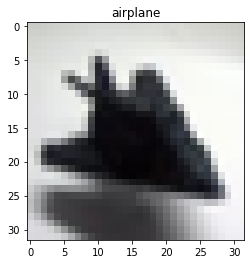

In [13]:
show_example(*dataset[0])

## Training and validation sets :

In [14]:
random_seed = 0
torch.manual_seed(random_seed);

In [15]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("Training set length : ", len(train_ds))
print("Validation set length : ", len(val_ds))

Training set length :  45000
Validation set length :  5000


## Create a dataloader to load the data in batches

In [16]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

In [17]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [18]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        plt.figure(figsize=(12, 6))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

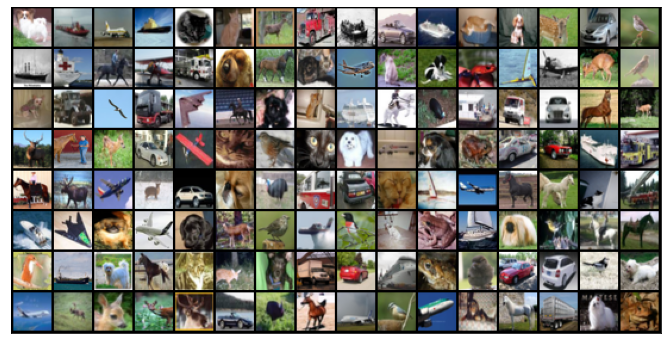

In [19]:
show_batch(train_dl)

## Modeling :(CNN)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss : {result['train_loss']}:.4f, val_loss: {result['val_loss']}:.4f, val_acc: {result['val_acc']}:.4f ")

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [24]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [25]:
for images, labels in train_dl:
    print('images shape : ', images.shape)
    out = model(images)
    print('out shape : ', out.shape)
    print('out[0] : ', out[0])
    break

images shape :  torch.Size([128, 3, 32, 32])
out shape :  torch.Size([128, 10])
out[0] :  tensor([ 0.0278, -0.0054, -0.0421,  0.0297, -0.0312,  0.0477,  0.0020,  0.0255,
        -0.0115,  0.0322], grad_fn=<SelectBackward0>)


## Defining a helper function to move the model to the GPU :

In [27]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cpu')

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Training the model :

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #Training
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
model = to_device(CnnModel(), device)

In [33]:
evaluate(model, val_dl)

{'val_acc': 0.09787453711032867, 'val_loss': 2.303257942199707}

In [34]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [35]:
def plot_accuracy(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, 'o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy/num-epochs')

In [36]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, 'o')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No of epcohs');

## Testing Phase :

In [37]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [38]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)

    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [39]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)

## Saving the model :

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')